In [1]:
import numpy as np
import pandas as pd
import math
from random import sample
import matplotlib.pyplot as plt

import imgaug.augmenters as iaa
import imgaug
from skimage import io

In [2]:
#data_dir = '/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification' 
data_dir = 'data'
image_width = 600
image_height = 600
channels = 3

In [3]:
df_train_full = pd.read_csv(data_dir+'/train.csv', dtype={'Id': str})
df_extra = pd.read_csv(data_dir+'/data.csv', dtype={'Id': str})
df_train_full = pd.concat([df_train_full, df_extra], ignore_index = True)
df_train_full['filename'] = data_dir+'/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,0875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


In [4]:
df_train_full.label.unique()

array(['glass', 'cup', 'spoon', 'plate', 'knife', 'fork'], dtype=object)

In [5]:
df_train_full.label.value_counts()

plate    1698
cup      1625
spoon    1512
knife    1357
glass    1020
fork      776
Name: label, dtype: int64

In [6]:
df_knife = df_train_full.query('label == "knife"').copy()
df_knife.reset_index(drop=True, inplace = True)
df_knife

,Id,label,filename
0,4617,knife,data/images/4617.jpg
1,4257,knife,data/images/4257.jpg
2,1717,knife,data/images/1717.jpg
3,7042,knife,data/images/7042.jpg
4,6826,knife,data/images/6826.jpg
...,...,...,...
1352,eu.2942d156-24b4-4159-9fd0-49535507ed72,knife,data/images/eu.2942d156-24b4-4159-9fd0-4953550...
1353,eu.46204b9f-951e-41c0-bd67-b3fc5ce72986,knife,data/images/eu.46204b9f-951e-41c0-bd67-b3fc5ce...
1354,eu.de331c11-b35d-4619-a45d-3a8e00af0d02,knife,data/images/eu.de331c11-b35d-4619-a45d-3a8e00a...
1355,eu.1a2df9ef-3027-4aed-bedf-3481f945b8a6,knife,data/images/eu.1a2df9ef-3027-4aed-bedf-3481f94...


In [7]:
knifes = []
for filename in df_knife.filename:
    image = io.imread(filename)
    knifes.append(image)


In [8]:
train_aug = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(1),
        iaa.Flipud(1), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.07, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 2.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.Sometimes(0.4, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug"
)

In [9]:
train_aug1 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(1),
        #iaa.Flipud(1), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Cutout(nb_iterations = (2, 5), size = (.07, .2)),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 2.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.Sometimes(0.4, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug1"
)

In [10]:
train_aug2 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        #iaa.Fliplr(1),
        iaa.Flipud(1), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.07, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 2.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.imgcorruptlike.GaussianNoise(severity=(1,4)),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug2"
)

In [11]:
knifes_aug = train_aug(images = sample(knifes, 350))
#knifes_aug += train_aug1(images = knifes)
#knifes_aug += train_aug2(images = sample(knifes, 1000))

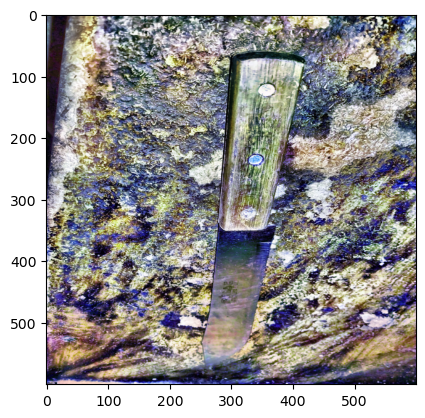

In [12]:
image = knifes_aug[168]
plt.imshow(image)

In [13]:
np.asarray(knifes_aug).shape

(350, 600, 600, 3)

In [14]:
len(knifes_aug)

350

In [15]:
df_knife_aug = pd.DataFrame(columns = ['Id', 'label'], dtype = str)
for i in range(len(knifes_aug)):
    file_name = 'knife_aug_'+str(i)
    io.imsave(data_dir+'/images/'+file_name+'.jpg', knifes_aug[i])
    df_knife_aug.loc[len(df_knife_aug)] = ['knife_aug_'+str(i), 'knife']
    
df_knife_aug

,Id,label
0,knife_aug_0,knife
1,knife_aug_1,knife
2,knife_aug_2,knife
3,knife_aug_3,knife
4,knife_aug_4,knife
...,...,...
345,knife_aug_345,knife
346,knife_aug_346,knife
347,knife_aug_347,knife
348,knife_aug_348,knife


In [16]:
df_knife_aug.to_csv(data_dir+'/knife_aug.csv', index = False)

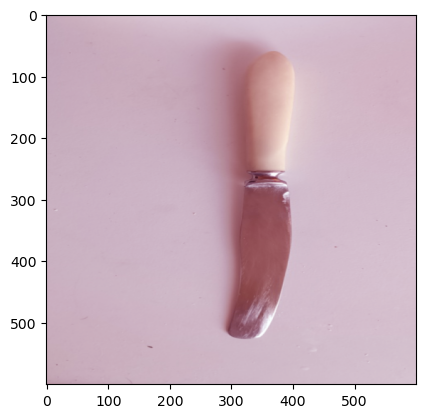

In [17]:
image = knifes_aug[221]
plt.imshow(image)